# A Time Series is Worth 64 Words: Long-term Forecasting with Transformers.

In [41]:
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

import pandas as pd

import torch
import torch.nn as nn
from transformers import PatchTSTForPrediction, PatchTSTConfig

%matplotlib inline

In [42]:
from src.data.make_dataset import get_train_test_datasets
from src.utils import forecasting, plot_forecasting, compute_mse

In [43]:
DIR_PATH = os.getcwd()

data_path = os.path.join(DIR_PATH, 'dataset')

## Lecture des données et création des datasets

In [44]:
from torch.utils.data import DataLoader

In [45]:
window_size = 720
sliding_window = 13
forecasting_horizon = 70

the_dataset = "ETTm1"

train_set, val_set, test_set = get_train_test_datasets(
    data_path+'/'+the_dataset +'.csv', 
    test_size=0.2, 
    window_size=window_size,
    sliding_size=sliding_window,
    forecasting_horizon=forecasting_horizon, 
    kind='sliding_window',
    validation_size=0.1
    )

num_channels = train_set[0][0].shape[0]

## Initialisation du modèle

In [46]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [47]:
patch_stride = 34

# Initializing an PatchTST configuration with 12 time steps for prediction
configuration = PatchTSTConfig(
    num_input_channels=num_channels,
    context_length=window_size,
    patch_stride=patch_stride,
    prediction_length=forecasting_horizon,
    random_mask_ratio=0.2,
    d_model=128,
    num_attention_heads=16,
    num_hidden_layers=3,
    ffn_dim=256,
    dropout=0.2,
    head_dropout=0.2,
    pooling_type=None,
    channel_attention=False,
    scaling="std",
    loss="mse",
    pre_norm=True,
    norm_type="batchnorm"
)

# Randomly initializing a model (with random weights) from the configuration
model = PatchTSTForPrediction(configuration)

# Accessing the model configuration
configuration = model.config

configuration

PatchTSTConfig {
  "_attn_implementation_autoset": true,
  "activation_function": "gelu",
  "attention_dropout": 0.0,
  "bias": true,
  "channel_attention": false,
  "channel_consistent_masking": false,
  "context_length": 346,
  "d_model": 128,
  "distribution_output": "student_t",
  "do_mask_input": null,
  "dropout": 0.2,
  "ff_dropout": 0.0,
  "ffn_dim": 256,
  "head_dropout": 0.2,
  "init_std": 0.02,
  "loss": "mse",
  "mask_type": "random",
  "mask_value": 0,
  "model_type": "patchtst",
  "norm_eps": 1e-05,
  "norm_type": "batchnorm",
  "num_attention_heads": 16,
  "num_forecast_mask_patches": [
    2
  ],
  "num_hidden_layers": 3,
  "num_input_channels": 7,
  "num_parallel_samples": 100,
  "num_targets": 1,
  "output_range": null,
  "patch_length": 1,
  "patch_stride": 34,
  "path_dropout": 0.0,
  "pooling_type": null,
  "positional_dropout": 0.0,
  "positional_encoding_type": "sincos",
  "pre_norm": true,
  "prediction_length": 70,
  "random_mask_ratio": 0.2,
  "scaling": "std"

## training

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.MSELoss()
batch_size = 64

num_epochs = 20

In [49]:
from tqdm import tqdm
from copy import deepcopy

def train(model, optimizer, criterion, batch_size, num_epochs, train_set, val_set, device, lr_scheduler, plot = False):

    model.to(device)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

    train_losses = []
    val_losses = []

    best_model = deepcopy(model)
    val_best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        num_samples = 0
        dloader_train = tqdm(train_loader, unit="batches")
        for i, (x, y, _, _) in enumerate(dloader_train, 1):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(x.permute(0,2,1))["prediction_outputs"]
            loss = criterion(y_hat, y.permute(0,2,1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_size
            num_samples += batch_size

            desc = "TRAIN : Epoch [{}/{}] - loss : {:.3f} ".format(epoch+1, num_epochs, train_loss/num_samples/y_hat.shape[2])
            dloader_train.set_description(desc)
        avg_train_loss = train_loss / num_samples / y_hat.shape[2]
        train_losses.append(avg_train_loss)
        
        with torch.no_grad():
            model.eval()
            val_loss = 0
            num_samples = 0
            dloader_val = tqdm(val_loader, unit="batches")
            for i, (x, y, _, _) in enumerate(dloader_val, 1):
                x, y = x.to(device), y.to(device)
                y_hat = model(x.permute(0,2,1))["prediction_outputs"]
                loss = criterion(y_hat, y.permute(0,2,1))
                val_loss += loss.item() * batch_size
                num_samples += batch_size

                desc = "VAL : Epoch [{}/{}] - loss : {:.3f} ".format(epoch+1, num_epochs, val_loss/num_samples/y_hat.shape[2])
                dloader_val.set_description(desc)
            avg_val_loss = val_loss / num_samples / y_hat.shape[2]
            val_losses.append(avg_val_loss)

        if avg_val_loss < val_best_loss:
            best_model = deepcopy(model)
            val_best_loss = avg_val_loss
            best_epoch = epoch + 1
        
        # lr_scheduler.step()
        
        if plot:
            clear_output(wait=True)
            plt.figure(figsize=(8,5))
            plt.semilogy(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o', zorder = 1)
            plt.semilogy(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='s', zorder = 2)
            plt.scatter(best_epoch, val_best_loss, c='red', label="Best Model", zorder = 3)
            plt.xlabel("Epochs")
            plt.ylabel("Loss (MSE) - log scale")
            plt.legend()
            plt.title("Training and Validation Loss per Epoch")
            plt.grid(True)
            plt.show()
    
    model.load_state_dict(best_model.state_dict())
        

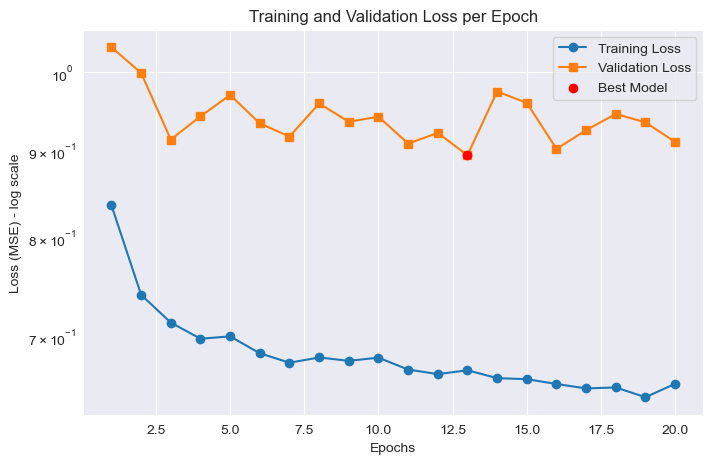

In [50]:
train(model, 
      optimizer, 
      criterion, 
      batch_size, 
      num_epochs, 
      train_set, 
      val_set, 
      device,
      lr_scheduler, 
      plot = True)

## Saving the model
model.save_pretrained(f"models/patchtst_{patch_stride}_{the_dataset}_{forecasting_horizon}")

In [51]:
model = PatchTSTForPrediction.from_pretrained(f"models/patchtst_{patch_stride}_{the_dataset}_{forecasting_horizon}")
model.to(device)

PatchTSTForPrediction(
  (model): PatchTSTModel(
    (scaler): PatchTSTScaler(
      (scaler): PatchTSTStdScaler()
    )
    (patchifier): PatchTSTPatchify()
    (masking): Identity()
    (encoder): PatchTSTEncoder(
      (embedder): PatchTSTEmbedding(
        (input_embedding): Linear(in_features=1, out_features=128, bias=True)
      )
      (positional_encoder): PatchTSTPositionalEncoding(
        (positional_dropout): Identity()
      )
      (layers): ModuleList(
        (0-2): 3 x PatchTSTEncoderLayer(
          (self_attn): PatchTSTAttention(
            (k_proj): Linear(in_features=128, out_features=128, bias=True)
            (v_proj): Linear(in_features=128, out_features=128, bias=True)
            (q_proj): Linear(in_features=128, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (dropout_path1): Identity()
          (norm_sublayer1): PatchTSTBatchNorm(
            (batchnorm): BatchNorm1d(128, eps=

### MSE Loss on `test_set`

In [52]:
compute_mse(model, test_set, device)

TEST : loss : 1.208 : 100%|██████████| 105/105 [00:01<00:00, 55.79batches/s]


1.2080323926445578

### forecasting

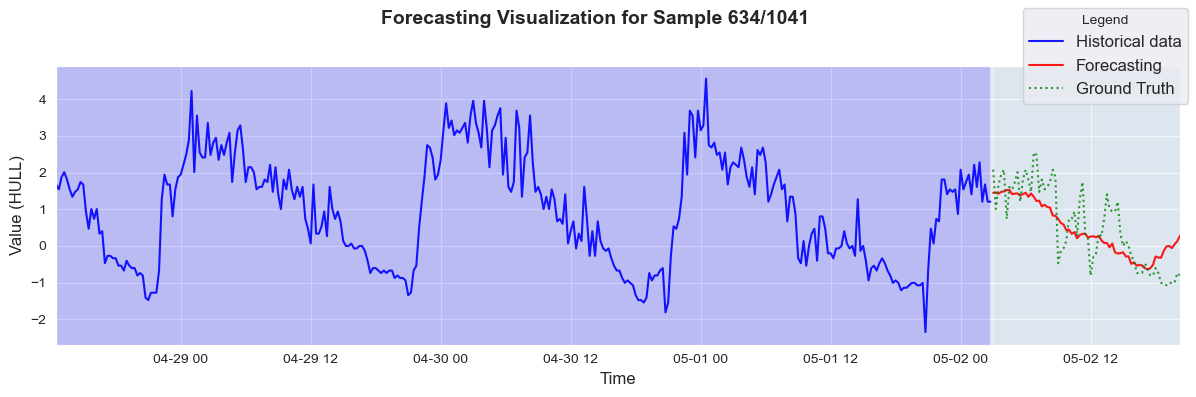

In [54]:
plot_forecasting(model, 
                 test_set, 
                 item = 634, 
                 columns_to_plot = ["HULL"],
                 device = device)

## Weather forecasting

With our model, we wan't to forecast the weather using the data of the [WS Saaleaue](https://www.bgc-jena.mpg.de/wetter/weather_data.html) station. We store our data in `/dataset/weather/`.

In [25]:
weather_folder = os.path.join(DIR_PATH, 'dataset/weather')

In [26]:
dataframes = []

for file in os.listdir(weather_folder):
    if file.endswith('.csv'):
        dataframes.append(pd.read_csv(os.path.join(weather_folder, file), index_col=0))

df = pd.concat(dataframes, axis=0)

# sort by date
df.index = pd.to_datetime(df.index, format="%d.%m.%Y %H:%M:%S")
df = df.sort_index()
df = df.drop_duplicates()
df.index.name = 'date'

# creating a new .csv file that is stored in the dataset folder
df.to_csv(os.path.join(DIR_PATH, 'dataset/mpi_full_saale.csv'))

### Loading the data

In [29]:
window_size = 720
sliding_window = 8
forecasting_horizon = 432 # 3 days

the_dataset = "mpi_full_saale"

train_set, val_set, test_set = get_train_test_datasets(
    data_path+'/' +the_dataset+'.csv', 
    test_size=0.3, 
    window_size=window_size,
    sliding_size=sliding_window,
    forecasting_horizon=forecasting_horizon, 
    kind='sliding_window',
    validation_size=0.15
    )

num_channels = train_set[0][0].shape[0]

### Model definition

In [30]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [28]:
patch_stride = sliding_window

# Initializing an PatchTST configuration with 12 time steps for prediction
config_PatchTST = PatchTSTConfig(
    num_input_channels=num_channels,
    context_length=window_size,
    patch_stride=patch_stride,
    prediction_length=forecasting_horizon,
    random_mask_ratio=0.5,
    d_model=144,
    num_attention_heads=24,
    num_hidden_layers=4,
    ffn_dim=256,
    dropout=0.1,
    head_dropout=0,
    pooling_type="mean",
    channel_attention=False,
    scaling="std",
    loss="mse",
    pre_norm=True,
    norm_type="batchnorm"
)

# Randomly initializing a model (with random weights) from the configuration
patchTST = PatchTSTForPrediction(config_PatchTST)

# Accessing the model configuration
config_PatchTST = model.config

config_PatchTST

PatchTSTConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "models/patchtst_13_weather_70",
  "activation_function": "gelu",
  "architectures": [
    "PatchTSTForPrediction"
  ],
  "attention_dropout": 0.0,
  "bias": true,
  "channel_attention": false,
  "channel_consistent_masking": false,
  "context_length": 700,
  "d_model": 128,
  "distribution_output": "student_t",
  "do_mask_input": null,
  "dropout": 0.2,
  "ff_dropout": 0.0,
  "ffn_dim": 256,
  "head_dropout": 0.2,
  "init_std": 0.02,
  "loss": "mse",
  "mask_type": "random",
  "mask_value": 0,
  "model_type": "patchtst",
  "norm_eps": 1e-05,
  "norm_type": "batchnorm",
  "num_attention_heads": 16,
  "num_forecast_mask_patches": [
    2
  ],
  "num_hidden_layers": 3,
  "num_input_channels": 21,
  "num_parallel_samples": 100,
  "num_targets": 1,
  "output_range": null,
  "patch_length": 1,
  "patch_stride": 13,
  "path_dropout": 0.0,
  "pooling_type": null,
  "positional_dropout": 0.0,
  "positional_encoding_typ

### training

In [26]:
optimizer = torch.optim.Adam(patchTST.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.MSELoss()

num_epochs = 20

train(model = patchTST, 
      optimizer = optimizer, 
      criterion = criterion, 
      batch_size = batch_size, 
      num_epochs = num_epochs, 
      train_set = train_set, 
      val_set = val_set, 
      device = device,
      lr_scheduler = lr_scheduler, 
      plot = True)

# Saving the model
patchTST.save_pretrained(f"models/patchtst_{patch_stride}_{the_dataset}_{forecasting_horizon}")

TRAIN : Epoch [1/20] - loss : 113.880 :   3%|▎         | 10/316 [00:12<06:21,  1.25s/batches]


KeyboardInterrupt: 

### Testing

In [31]:
patchTST = PatchTSTForPrediction.from_pretrained("models/patchtst_mpi_full_saale")
patchTST.to(device)

PatchTSTForPrediction(
  (model): PatchTSTModel(
    (scaler): PatchTSTScaler(
      (scaler): PatchTSTStdScaler()
    )
    (patchifier): PatchTSTPatchify()
    (masking): Identity()
    (encoder): PatchTSTEncoder(
      (embedder): PatchTSTEmbedding(
        (input_embedding): Linear(in_features=1, out_features=144, bias=True)
      )
      (positional_encoder): PatchTSTPositionalEncoding(
        (positional_dropout): Identity()
      )
      (layers): ModuleList(
        (0-3): 4 x PatchTSTEncoderLayer(
          (self_attn): PatchTSTAttention(
            (k_proj): Linear(in_features=144, out_features=144, bias=True)
            (v_proj): Linear(in_features=144, out_features=144, bias=True)
            (q_proj): Linear(in_features=144, out_features=144, bias=True)
            (out_proj): Linear(in_features=144, out_features=144, bias=True)
          )
          (dropout_path1): Identity()
          (norm_sublayer1): PatchTSTBatchNorm(
            (batchnorm): BatchNorm1d(144, eps=

#### MSE Loss on `test_set`

In [32]:
compute_mse(patchTST, test_set, device)

TEST : loss : 61.277 : 100%|██████████| 407/407 [01:05<00:00,  6.23batches/s]


61.27714987714988

### Forecastion

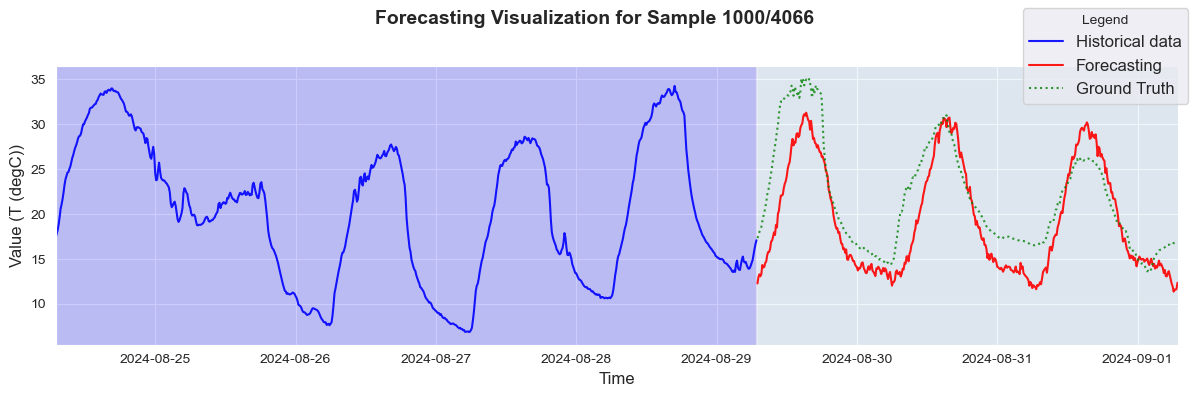

In [40]:
plot_forecasting(patchTST, test_set, 1000, device, columns_to_plot=["T (degC)"])